# Image download

- Defined a function that downloads the images from the url in JSON into the specified folder
- Some urls are not found: for now, I just ignore them and exclude from the output dataset
   - 40 in train, 11 in val with error 404

In [1]:
import pathlib as pl
import pandas as pd
from tqdm import tqdm
import urllib.request as req
import shutil

def download_images(json_path, split, dst_path):
    # read the json file we want to download images from
    json_path = pl.Path(json_path)
    json_dir = pl.Path(json_path).parent
    with open(json_path, 'r') as f:
        data = pd.read_json(f, orient='index')
    # get the selected split from the json
    df = data[data.split == split].copy().reset_index()
    # get the download folder
    dst_path = pl.Path(dst_path)
    dst_path.mkdir(parents=False, exist_ok=True)
    errors = 0
    for i, url in enumerate(tqdm(df['img_url'])):
        filename = pl.Path(url).name
        file_path = dst_path / filename
        if not pl.Path(file_path).exists():
            request = req.Request(url)
            request.add_header('User-Agent', 'CulturalHeritageBot/0.0 (dario.cioni@stud.unifi.it)')
            try:
                response = req.urlopen(request)
            except Exception as e:
                errors += 1
                print("Cannot find {}, error code: {}".format(url, e.code))
                df.drop(labels=i, axis=0,inplace=True)
                continue
            else:
                out_file = open(file_path, 'wb')
                shutil.copyfileobj(response, out_file)
        df.loc[i, 'img_url'] = file_path
    print("Process finished. Found {} errors".format(errors))
    df.to_json(json_dir / '{}.json'.format(split), orient='index', default_handler=str)

# download_images('./data/artpedia/artpedia.json','val','./data/artpedia/images')

# Dataset definition
- Defined a custom Dataset, which returns an image and a description of the image, randomly sampled from `visual_sentences`

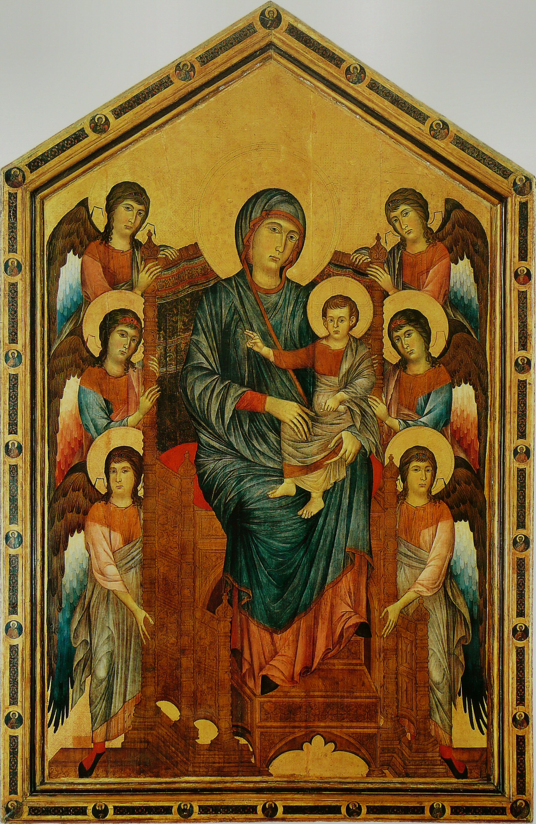

The throne is similar to the Maestà painted by Cimabue in the Basilica of San Francesco di Assisi (1288–1292).


In [2]:
from data_loader.data_loaders import ArtpediaDataset, ArtpediaDataLoader
from transformers import AutoProcessor, AutoModel, AutoModelForCausalLM

dataset = ArtpediaDataset('./data/artpedia', train=True, image_transform=None, processor=None)

image, label = dataset[0]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))
print(label[0])

# Model definition
- Defined a DataLoader which extends the BaseDataLoader class. The image is transformed by resizing to $224 \times 224$ and then processed by HuggingFace AutoProcessor
- Todo: integrate those steps in the DataLoader allowing to choose the right processor and transformations for each model (or define specific DataLoader for each model)

In [3]:
train_data = ArtpediaDataLoader('./data/artpedia',batch_size=2,validation_split=0.1,num_workers=1,training=True)
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [4]:
processor = train_data.dataset.processor

batch = next(iter(train_data))
for k,v in batch.items():
  print(k,v.shape)

# inputs = processor(labels, images=images, return_tensors="pt")
pixel_values = batch['pixel_values'][0].unsqueeze(0)
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
# outputs = model(input_ids=batch["input_ids"],
#             attention_mask=batch["attention_mask"],
#             pixel_values=batch["pixel_values"],
#             labels=batch["input_ids"])
print("Original: {} \n Generated: {}".format(processor.decode(batch["input_ids"][0]),generated_caption))

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])
Original: [CLS] her eyes and hair are light brown, her skin is pale, and her body is slightly turned to the left side, while her head gives balance by being turned to the opposite side. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

Check images by decoding an image from the batch

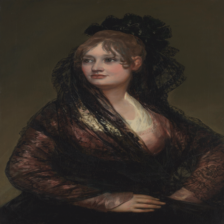

In [5]:
from PIL import Image
import numpy as np

# Mean and STD calculated on Imagenet
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

# Training
Let's try to overfit on a single batch

In [6]:
import torch
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

batch = next(iter(train_data))
for k,v in batch.items():
  print(k,v.shape)

for epoch in range(50):

    # for idx, batch in enumerate(tqdm(train_data)):
    input_ids = batch["input_ids"].to(device)
    pixel_values = batch["pixel_values"].to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss
    print("Epoch: {:d} | loss: {:.3f}".format(epoch,loss))
    # print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])
Epoch: 0 | loss: 11.912
Epoch: 1 | loss: 10.449
Epoch: 2 | loss: 9.946
Epoch: 3 | loss: 9.644
Epoch: 4 | loss: 9.406
Epoch: 5 | loss: 9.170
Epoch: 6 | loss: 8.968
Epoch: 7 | loss: 8.748
Epoch: 8 | loss: 8.585
Epoch: 9 | loss: 8.418
Epoch: 10 | loss: 8.286
Epoch: 11 | loss: 8.151
Epoch: 12 | loss: 8.022
Epoch: 13 | loss: 7.903
Epoch: 14 | loss: 7.785
Epoch: 15 | loss: 7.676
Epoch: 16 | loss: 7.568
Epoch: 17 | loss: 7.457
Epoch: 18 | loss: 7.353
Epoch: 19 | loss: 7.247
Epoch: 20 | loss: 7.148
Epoch: 21 | loss: 7.045
Epoch: 22 | loss: 6.941
Epoch: 23 | loss: 6.837
Epoch: 24 | loss: 6.736
Epoch: 25 | loss: 6.630
Epoch: 26 | loss: 6.527
Epoch: 27 | loss: 6.424
Epoch: 28 | loss: 6.319
Epoch: 29 | loss: 6.215
Epoch: 30 | loss: 6.113
Epoch: 31 | loss: 6.007
Epoch: 32 | loss: 5.904
Epoch: 33 | loss: 5.801
Epoch: 34 | loss: 5.694
Epoch: 35 | loss: 5.590
Epoch: 36 | loss: 5.486
Epoch: 37 |

In [8]:
from model.metric import bleu
processor = AutoProcessor.from_pretrained("microsoft/git-base")#train_data.dataset.processor

for k,v in batch.items():
  print(k,v.shape)

# inputs = processor(labels, images=images, return_tensors="pt")
for i in range(len(batch)-1):
    pixel_values = batch['pixel_values'][i].unsqueeze(0).to(device)
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    # outputs = model(input_ids=batch["input_ids"],
    #             attention_mask=batch["attention_mask"],
    #             pixel_values=batch["pixel_values"],
    #             labels=batch["input_ids"])
    print("Original: {} \n Generated: {}".format(processor.decode(batch["input_ids"][i],skip_special_tokens=True),generated_caption))

    print(bleu([processor.decode(batch["input_ids"][i],skip_special_tokens=True)],[generated_caption]))


input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])
Original: woman with a mirror 
 Generated: woman with a mirror
tensor(1.)
Original: they depict scenes embodying compositions of figural and metaphorical imagery that may be seen as visually reflecting the intimate and dramatic relationship between othello and desdemona, and the tense and uneasy relation that passes between and through othello, desdemona and iago. 
 Generated: they depict scenes embodying compositions of figural and metaphorical imagery that may be seen as visually reflecting the intimate and dramatic relationship between othello and desdemona, and the tense and iago.
tensor(0.7334)
